In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [2]:
data = "../data/robot_data.csv"

In [3]:
df = pd.read_csv(data,header=None, names=['wheel_l','wheel_r','beta_l','beta_r','alpha', 'i', 'j'])

In [4]:
i_filter = 1
j_filter = 0

In [5]:
filtered = df[(df.i == i_filter) & (df.j == j_filter)].reset_index()
filtered

,index,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,184,5.045506,8.647794,-0.017502,0.021673,-0.030077,1.0,0.0
1,189,5.693804,9.232234,-0.016203,0.022134,-0.027398,1.0,0.0
2,194,6.831158,9.513143,-0.012312,0.015879,-0.016583,1.0,0.0
3,253,5.048041,8.647728,-0.017783,0.021551,-0.029797,1.0,0.0
4,258,5.695350,9.231703,-0.016133,0.022359,-0.026944,1.0,0.0
...,...,...,...,...,...,...,...,...
243,8253,5.045590,8.647789,-0.017542,0.021673,-0.029820,1.0,0.0
244,8258,5.693855,9.232214,-0.016282,0.022085,-0.027155,1.0,0.0
245,8263,6.831182,9.513110,-0.012468,0.015787,-0.016580,1.0,0.0
246,8302,5.045590,8.647789,-0.017735,0.021752,-0.029941,1.0,0.0


In [6]:
class Robot():
    def __init__(self, data) -> None:
        self.data = data
   

In [7]:
filtered.beta_l.size/4

62.0

In [8]:
robots = [Robot(filtered[i*64:(i+1)*64]) for i in range(4)]

In [9]:
def local_first_estimate(data):
    # Example data
    omega_l = data.wheel_l.values
    omega_r = data.wheel_r.values
    beta_l = data.beta_l.values
    beta_r = data.beta_r.values
    alpha = data.alpha.values
    Y = np.column_stack((beta_l, beta_r, alpha))

    # Initial OLS regression to get residuals
    X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
    theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    y_hat_ols = X @ theta_hat_ols
    residuals_ols = Y - y_hat_ols

    # Estimate weights as the inverse of the squared residuals
    weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-10) 
    weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-10) 
    weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-10) 

    # Create individual diagonal weight matrices for each output
    W_l = np.diag(weights_l)
    W_r = np.diag(weights_r)
    W_alpha = np.diag(weights_alpha)

    # Combine these into a block diagonal matrix
    W = block_diag(W_l, W_r, W_alpha)

    # Expand X to match the block diagonal structure
    X_expanded = np.kron(np.eye(3), X)  # Kronecker product to create the expanded X matrix

    F_0 = X_expanded.T @ W @ X_expanded
    a_0 = X_expanded.T @ W @ Y.flatten(order='F')
    # Now compute WLS using the expanded X and Y
    XTWX_inv = np.linalg.inv(F_0)
    XTWy = a_0
    beta_hat_wls_flat = XTWX_inv @ XTWy

    # Reshape the result back to the original coefficient shape
    beta_hat_wls = beta_hat_wls_flat.reshape(3, -1).T
    
    print("WLS Estimated coefficients:", beta_hat_wls)
    return F_0, a_0, beta_hat_wls


In [10]:
msg = {}

for i, robot in enumerate(robots):
    robot.F, robot.a, robot.beta_hat_wls = local_first_estimate(robot.data)
    msg[f"tractor{i}"] = {"F": robot.F, "a": robot.a}

WLS Estimated coefficients: [[-0.02404083 -0.025467   -0.02034025]
 [ 0.00358469 -0.00826205  0.01100351]
 [-0.00135245  0.01026842 -0.00752044]]
WLS Estimated coefficients: [[-0.02226486 -0.02419864 -0.01904477]
 [ 0.0037274  -0.00813587  0.01106296]
 [-0.00164185  0.01004372 -0.00770034]]
WLS Estimated coefficients: [[-0.02394782 -0.02610377 -0.0208913 ]
 [ 0.0036081  -0.00827125  0.01102178]
 [-0.00137896  0.0103396  -0.00747498]]
WLS Estimated coefficients: [[-0.02243562 -0.02401089 -0.02092856]
 [ 0.00368905 -0.0081597   0.01095163]
 [-0.00159698  0.01004011 -0.00742025]]


In [11]:
def global_estimate(msg):

    sum_F = np.zeros((9,9))
    sum_a = np.zeros((9,))

    for i in msg.keys():
        sum_F += msg[i]["F"]
        sum_a += msg[i]["a"]

    beta_hat_wls_global = np.linalg.inv(sum_F) @ sum_a
    
    return beta_hat_wls_global.reshape(3, -1).T

In [12]:
beta_hat_wls_global = global_estimate(msg)

In [13]:
beta_hat_wls_global

array([[-0.0232205 , -0.02514792, -0.02010254],
       [ 0.00365267, -0.00821765,  0.01101279],
       [-0.00148776,  0.01020179, -0.00755223]])

In [14]:
class WLSRegressor():
    def __init__(self, F = None, a = None, theta = np.zeros((3,3))) -> None:
        
        self.F = F
        self.a = a
        self.theta = theta

In [15]:
class MapSlippageLocalWLSEstimator():

    def __init__(self, height, width, id) -> None:

        self.height = height
        self.width = width

        self.id = id

        self.map_wls_regressors = [
            [WLSRegressor() for j in range(width)] for i in range(height)]

    def local_first_estimate(self, data):
        # Example data
        omega_l = data.wheel_l.values
        omega_r = data.wheel_r.values
        beta_l = data.beta_l.values
        beta_r = data.beta_r.values
        alpha = data.alpha.values
        Y = np.column_stack((beta_l, beta_r, alpha))

        # Initial OLS regression to get residuals
        X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
        theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
        y_hat_ols = X @ theta_hat_ols
        residuals_ols = Y - y_hat_ols

        # Estimate weights as the inverse of the squared residuals
        weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-10)
        weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-10)
        weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-10)

        # Create individual diagonal weight matrices for each output
        W_l = np.diag(weights_l)
        W_r = np.diag(weights_r)
        W_alpha = np.diag(weights_alpha)

        # Combine these into a block diagonal matrix
        W = block_diag(W_l, W_r, W_alpha)

        # Expand X to match the block diagonal structure
        # Kronecker product to create the expanded X matrix
        X_expanded = np.kron(np.eye(3), X)

        F_0 = X_expanded.T @ W @ X_expanded
        a_0 = X_expanded.T @ W @ Y.flatten(order='F')
        # Now compute WLS using the expanded X and Y
        XTWX_inv = np.linalg.inv(F_0)
        XTWy = a_0
        beta_hat_wls_flat = XTWX_inv @ XTWy

        # Reshape the result back to the original coefficient shape
        beta_hat_wls = beta_hat_wls_flat.reshape(3, -1).T

        print("WLS Estimated coefficients:", beta_hat_wls)
        return F_0, a_0, beta_hat_wls

    def compute_wls_regressor(self, data):
        for i in range(self.width):
            for j in range(self.height):
                filtered = data[(data.i == i) & (data.j == j)]
                if len(filtered):
                    self.map_wls_regressors[i][j].F, self.map_wls_regressors[i][j].a, self.map_wls_regressors[i][j].theta = self.local_first_estimate(
                        filtered)

    def generate_msg(self):
        msg = {self.id: {}}
        for i in range(self.width):
            msg[self.id][i] = {}
            for j in range(self.height):
                msg[self.id][i][j] = {"F": self.map_wls_regressors[i][j].F, "a": self.map_wls_regressors[i][j].a}

        return msg

In [16]:
len(pd.DataFrame())

0

In [17]:
map_slippage_wls0 = MapSlippageLocalWLSEstimator(3,3,"tractor0")
map_slippage_wls1 = MapSlippageLocalWLSEstimator(3,3,"tractor1")
map_slippage_wls2 = MapSlippageLocalWLSEstimator(3,3,"tractor2")

In [18]:
map_slippage_wls0.compute_wls_regressor(df)
map_slippage_wls1.compute_wls_regressor(df)
map_slippage_wls2.compute_wls_regressor(df)

WLS Estimated coefficients: [[ 0.00734189 -0.01017238  0.00298515]
 [ 0.00960694 -0.01070149  0.00138654]
 [-0.00963703  0.01092939 -0.00182617]]
WLS Estimated coefficients: [[-0.00233146 -0.0009914   0.02449277]
 [ 0.00442764 -0.00515444  0.01430455]
 [-0.0038904   0.00556817 -0.01665041]]
WLS Estimated coefficients: [[-0.06783623  0.01329957  0.00242652]
 [-0.02785617  0.00276398  0.0012649 ]
 [ 0.03237628 -0.00345102 -0.00142757]]
WLS Estimated coefficients: [[-0.02319745 -0.02497758 -0.02036458]
 [ 0.00365193 -0.00821042  0.01100247]
 [-0.00148962  0.01017855 -0.00751721]]
WLS Estimated coefficients: [[ 0.0168831   0.00239163 -0.00550735]
 [ 0.00871031 -0.00427242  0.00903281]
 [-0.01023672  0.00404723 -0.00763092]]


WLS Estimated coefficients: [[-0.00475863  0.00744637 -0.02436471]
 [ 0.00653186 -0.00725102  0.01234487]
 [-0.00561521  0.0058101  -0.00727578]]
WLS Estimated coefficients: [[-0.00609111  0.00069923  0.0744525 ]
 [ 0.00950627 -0.00863537 -0.01395607]
 [-0.00957026  0.0099712  -0.00330314]]
WLS Estimated coefficients: [[-0.01062177 -0.00208864  0.00694982]
 [ 0.00473247 -0.00577019  0.00875792]
 [-0.00296418  0.00602721 -0.008792  ]]
WLS Estimated coefficients: [[ 0.00734189 -0.01017238  0.00298515]
 [ 0.00960694 -0.01070149  0.00138654]
 [-0.00963703  0.01092939 -0.00182617]]
WLS Estimated coefficients: [[-0.00233146 -0.0009914   0.02449277]
 [ 0.00442764 -0.00515444  0.01430455]
 [-0.0038904   0.00556817 -0.01665041]]
WLS Estimated coefficients: [[-0.06783623  0.01329957  0.00242652]
 [-0.02785617  0.00276398  0.0012649 ]
 [ 0.03237628 -0.00345102 -0.00142757]]
WLS Estimated coefficients: [[-0.02319745 -0.02497758 -0.02036458]
 [ 0.00365193 -0.00821042  0.01100247]
 [-0.00148962  0.0

In [19]:
msgs = [map_slippage_wls0.generate_msg(), map_slippage_wls1.generate_msg(), map_slippage_wls2.generate_msg()]

In [20]:
msgs[0]

{'tractor0': {0: {0: {'F': array([[1.00081541e+11, 3.18386841e+11, 4.92681944e+11, 0.00000000e+00,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [3.18386841e+11, 1.75004851e+12, 2.27055531e+12, 0.00000000e+00,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [4.92681944e+11, 2.27055531e+12, 3.09739879e+12, 0.00000000e+00,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.92624002e+10,
            1.62406724e+11, 1.90727975e+11, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62406724e+11,
            1.39308707e+12, 1.63380483e+12, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.90727975e+

In [21]:
class MapSlippageDistributedWLSEstimator():

    def __init__(self, height, width) -> None:

        self.height = height
        self.width = width

        self.map_wls_regressors = [
            [WLSRegressor() for j in range(width)] for i in range(height)]

    def global_estimate(self, msg):

        sum_F = np.zeros((9, 9))
        sum_a = np.zeros((9,))

        for i in msg.keys():
            if isinstance(msg[i]["F"], np.ndarray):
                sum_F += msg[i]["F"]
                sum_a += msg[i]["a"]

        if np.all(sum_F  == 0.):
            beta_hat_wls_global = np.zeros((9,1))
        else:
            beta_hat_wls_global = np.linalg.inv(sum_F) @ sum_a

        return beta_hat_wls_global.reshape(3, -1).T

    def compute_wls_regressor(self, msgs):
        for i in range(self.width):
            for j in range(self.height):
                patch_msg = {}
                for msg in msgs:
                    id = list(msg.keys())[0]
                    # print(id, i, j)
                    patch_msg[id] = msg[id][i][j]

                # print(list(patch_msg.keys()))
                self.map_wls_regressors[i][j].theta = self.global_estimate(
                    patch_msg)

In [22]:
global_wls = MapSlippageDistributedWLSEstimator(3,3)

In [23]:
global_wls.compute_wls_regressor(msgs)

In [24]:
for i in range(3):
    for j in range(3):
        print(global_wls.map_wls_regressors[i][j].theta)

[[ 0.00734189 -0.01017238  0.00298515]
 [ 0.00960694 -0.01070149  0.00138654]
 [-0.00963703  0.01092939 -0.00182617]]
[[-0.00233146 -0.0009914   0.02449277]
 [ 0.00442764 -0.00515444  0.01430455]
 [-0.0038904   0.00556817 -0.01665041]]
[[-0.06783623  0.01329957  0.00242652]
 [-0.02785617  0.00276398  0.0012649 ]
 [ 0.03237628 -0.00345102 -0.00142757]]
[[-0.02319745 -0.02497758 -0.02036458]
 [ 0.00365193 -0.00821042  0.01100247]
 [-0.00148962  0.01017855 -0.00751721]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.0168831   0.00239163 -0.00550735]
 [ 0.00871031 -0.00427242  0.00903281]
 [-0.01023672  0.00404723 -0.00763092]]
[[-0.00475863  0.00744637 -0.02436471]
 [ 0.00653186 -0.00725102  0.01234487]
 [-0.00561521  0.0058101  -0.00727578]]
[[-0.00609111  0.00069923  0.0744525 ]
 [ 0.00950627 -0.00863537 -0.01395607]
 [-0.00957026  0.0099712  -0.00330314]]
[[-0.01062177 -0.00208864  0.00694982]
 [ 0.00473247 -0.00577019  0.00875792]
 [-0.00296418  0.00602721 -0.008792  ]]


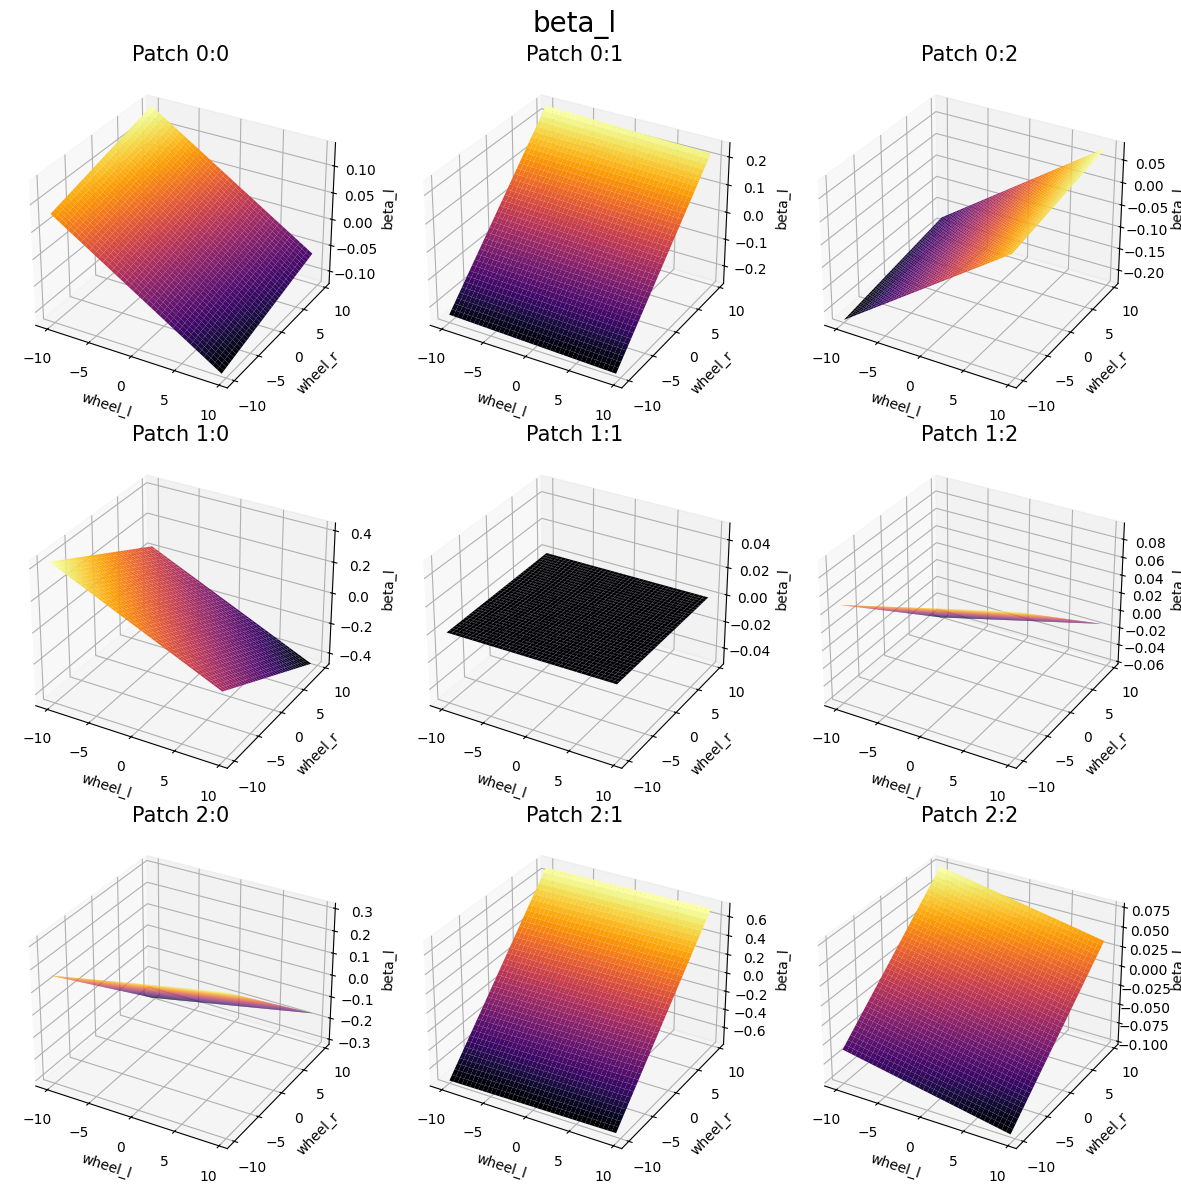

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create figure and 3x3 subplots
fig, axes = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, figsize=(12, 12))

# Set a large title for the entire figure
fig.suptitle("beta_l", fontsize=20)

# Loop through the 3x3 grid to plot something on each subplot
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        # Example data: plotting a simple surface
        wheel_l, wheel_r = np.meshgrid(np.arange(-10, 10, 0.5), np.arange(-10, 10, 0.5))
        theta = global_wls.map_wls_regressors[i][j].theta[0]  # Assuming this is the data you want to plot
        wls = theta[0] + theta[1] * wheel_l + theta[2] * wheel_r
        ax.plot_surface(wheel_l, wheel_r, wls, cmap="inferno")
        ax.set_title(f"Patch {i}:{j}", fontsize=15)  # Optional: adjust fontsize
        ax.set_xlabel("wheel_l")
        ax.set_ylabel("wheel_r")
        ax.set_zlabel("beta_l")  # Optional: You can label the z-axis if needed

# Adjust the layout to be compact with more padding
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase space between subplots

# Adjust layout to avoid overlap of suptitle
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust rect to accommodate the suptitle

# Display the plot
plt.show()
